In [1]:
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


# Estimación de densidad

## 1) Estimación de densidad por kernel

La mayoría de los problemas en astronomía (¿y ciencia?) involucran o requieren estimar una distribución de densidad subyacente dadas algunas observaciones discretas (a menudo ruidosas). Más generalmente, esencialmente todos los problemas de inferencia estadística se reducen a estimar la densidad de probabilidad sobre algunos parámetros o calcular integrales sobre densidades de probabilidad. Cuando nuestros modelos son _paramétricos_, usamos algoritmos como MCMC para generar muestras de distribuciones de densidad sobre los parámetros de nuestro modelo. Pero a veces (1) no tenemos un modelo, (2) tenemos un modelo paramétrico pero puramente numérico, o (3) queremos visualizar rápidamente la densidad dadas muestras discretas. En estos casos, podemos hacer una estimación de densidad _no paramétrica_.

Como astrónomos, la estimación de densidad no paramétrica es una de las primeras habilidades de análisis / visualización de datos que aprendemos: ¡Todos conocemos y amamos el histograma!

#### Cómo hacer astronomía:

1. Descubre objeto / fenómeno
2. Encuentra / crea una muestra
3. Haz un histograma
4. ??
5. Beneficio

El histograma es una excelente herramienta para la visualización: es rápido y es un estándar (la gente sabe cómo leerlo). Pero hay algunas advertencias importantes ([ver esta excelente publicación de blog de DFM](http://dfm.io/posts/histogram1/)) que otros métodos mejoran. En particular, las conclusiones que extraemos al observar un histograma a menudo dependen en gran medida de la elección de los bins, tanto de las ubicaciones de los bins como de los anchos de los bins.

Por ejemplo, generemos histogramas de algunos datos puntuales en 1D: en los gráficos a continuación, todos los histogramas se hacen con los mismos puntos (variable `x` a continuación), pero con diferentes opciones para los anchos de los bins y las posiciones de los bins:


In [2]:
np.random.seed(42)
x1 = np.random.normal(0.25, 0.1, size=200)
x2 = np.random.normal(1., 0.5, size=1000)
x = np.concatenate((x1, x2))
np.random.shuffle(x)  # ¡confiaremos en esto más tarde!

def true_x_density(x):
    return ((1/6)*norm.pdf(x, loc=0.25, scale=0.1) + 
            (5/6)*norm.pdf(x, loc=1., scale=0.5))


De izquierda a derecha desplazamos todos los bins con un número fijo de bins, de arriba a abajo cambiamos el número de bins:


AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

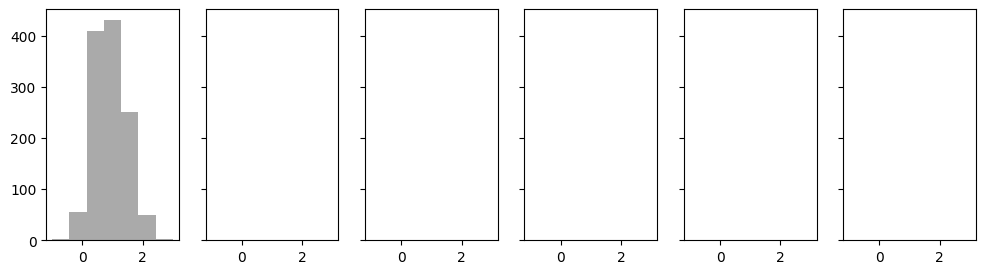

In [3]:
for n_bins in [8, 12, 16]:
    bins = np.linspace(-1, 3, n_bins)

    fig, axes = plt.subplots(1, 6, figsize=(12, 3), 
                             sharex=True, sharey=True)
    
    x_grid = np.linspace(-1, 3, 1000)
    for i, ax in enumerate(axes.flat):
        ax.hist(x, bins=bins + i/20, normed=True, color='#aaaaaa')
        ax.plot(x_grid, true_x_density(x_grid), marker='', 
                alpha=0.75, zorder=10, color='tab:orange')
    
    axes[0].set_title('{0} bins'.format(n_bins), fontsize=20)
    fig.tight_layout()


¿La distribución anterior es unimodal o bimodal?

En un histograma, las ubicaciones y anchuras de los bins son fijas, y la densidad en la ubicación de cada bin se estima "moviendo" los puntos de datos en cada bin y contando. ¿Cómo podríamos estimar la densidad en una ubicación usando bins? Podríamos, en su lugar, fijar los anchos de los bins y las ubicaciones de los puntos de datos, y mover las ubicaciones de los bins para que se superpongan y estén centrados en cada punto de datos.


In [ ]:
def point_centered_histogram(x, bin_width, data):
    data = np.array(data)
    x = np.array(x)
    y = (data[None] - x[:, None]) / (bin_width/2.)
    return np.sum(np.abs(y) < 1., axis=1) / (len(data) * bin_width)


Probemos esto con algunos datos triviales para comenzar antes de aplicarlo a los datos puntuales de arriba:


In [ ]:
x_grid = np.linspace(0, 4, 512)
data = [1., 1.2, 3.]
bin_widths = [0.1, 0.3, 1.]

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.plot(x_grid, point_centered_histogram(x_grid, bin_widths[i], data), 
            marker='', drawstyle='steps-mid')
    
    ax.set_title('width={0:.1f}'.format(bin_widths[i]))


En el panel de la izquierda, cuando el ancho del bin es pequeño, vemos cómo nuestros "bins" ahora están centrados en los datos mismos. A medida que aumentamos el ancho del bin (de izquierda a derecha), vemos que se nos permite que nuestros bins se superpongan. Aquí hemos eliminado la necesidad de especificar las ubicaciones de los bins, pero aún necesitamos especificar el ancho del bin. ¡Lo que hemos implementado aquí es una _estimación de densidad por kernel_ de la densidad subyacente, donde nuestro kernel es una función de sombrero plano! Veamos cómo funciona con nuestro conjunto de datos anterior:


In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(12, 3), 
                         sharex=True, sharey=True)

bin_widths = np.logspace(-1, 1, len(axes))

x_grid = np.linspace(-1, 3, 1024)
for i, ax in enumerate(axes.flat):
    ax.plot(x_grid, point_centered_histogram(x_grid, bin_widths[i], x), 
            marker='', drawstyle='steps-mid')
    
    ax.plot(x_grid, true_x_density(x_grid), 
            zorder=-10, marker='')

    ax.set_title('width={0:.1f}'.format(bin_widths[i]), fontsize=20)
fig.tight_layout()


Cuando el tamaño del bin es pequeño, la densidad estimada es muy ruidosa. A medida que aumentamos el ancho del bin, el cual a menudo se llama __ancho de banda__, las características a pequeña escala se desvanecen (al igual que en un histograma estándar). ¡En algún lugar alrededor de width=0.3–0.5, la estimación de la densidad parece bastante buena (la verdadera densidad se representa en azul)!

Pero aquí es donde la estimación de densidad por kernel se vuelve interesante: ¡El sombrero plano es solo una opción para una función kernel! Hay muchas más que podemos elegir. A continuación, vamos a suponer que estamos trabajando con datos en 1D (ver otros recursos para las expresiones en casos de dimensiones más altas). La idea clave es la misma que la de arriba: nuestra estimación de densidad en una ubicación dada, $ \hat{f}(x) $, dada alguna función kernel $ K(z) $ y ancho de banda $ b $ se calcula como

$$    \hat{f}(x) = \frac{1}{N} \, \frac{1}{b} \, \sum_n^N K \left( \frac{|x - x_n|}{b} \right)$$

donde los $ N $ puntos de datos están indexados como $ x_n $.

Arriba, usamos el __kernel de sombrero plano__:

$$
    K(z) = 
    \begin{cases}
        1, & \text{si} \ z \leq 1 \\
        0, & \text{de lo contrario}
    \end{cases}
$$

Otras opciones populares son el __kernel Gaussiano__:

$$
    K(z) = \frac{1}{\sqrt{2\pi}} \, \exp \left(-\frac{z^2}{2} \right)
$$

y el __kernel Epanechnikov__:

$$
    K(z) = \frac{3}{4} \, (1 - z^2)
$$

Todos los kernels anteriores están implementados en `scikit-learn`; ahora vamos a usar `scikit-learn` para construir KDE's de los datos anteriores usando los diferentes kernels, pero el mismo ancho de banda:


In [ ]:
kde_tophat = KernelDensity(bandwidth=0.2, kernel='tophat')
kde_gauss = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde_epan = KernelDensity(bandwidth=0.2, kernel='epanechnikov')
kdes = [kde_tophat, kde_gauss, kde_epan]

In [ ]:
X = x.reshape(-1, 1)
for kde in kdes:
    kde.fit(X)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), 
                         sharex=True, sharey=True)

x_grid = np.linspace(-1, 3, 1024)
for ax, kde in zip(axes.flat, kdes):
    ax.plot(x_grid, np.exp(kde.score_samples(x_grid.reshape(-1, 1))),
            marker='', drawstyle='steps-mid')
    
    ax.plot(x_grid, true_x_density(x_grid), 
            zorder=-10, marker='', color='tab:orange')
    
    ax.set_title(kde.kernel)
    
fig.tight_layout()


Sorprendentemente, de acuerdo a nuestra intuición (o reacción instintiva de usar Gaussianas en todas partes), ¡la estimación Gaussiana con este ancho de banda parece ser la peor! ¿Qué diferencia al kernel Gaussiano de los otros aquí? ¡Tiene alas hasta el infinito! El kernel Gaussiano puede funcionar bien en las KDE, pero la elección del ancho de banda importa mucho.



## Selección del ancho de banda

Con un histograma, tenemos que especificar las ubicaciones y anchos de los bins. Con la estimación de densidad por kernel, todavía tenemos que establecer la longitud de escala o ancho de banda del kernel. El ancho de banda controla cuán suave será la estimación de densidad resultante y, por lo tanto, tiene un gran impacto en nuestras conclusiones. Entonces, ¿cómo elegimos este ancho de banda? 

__¡validación cruzada!__ (CV)

En resumen: podemos retener algunos datos al azar, construir la estimación de densidad, calcular la verosimilitud de los datos retenidos bajo el KDE y luego optimizar el ancho de banda usando la verosimilitud total.

En un poco más de detalle: la validación cruzada es un esquema muy general para evaluar modelos. Generalmente se usa en la comunidad de aprendizaje automático como una forma de establecer hiperparámetros de modelos. La idea general es dividir sus datos en dos grupos: un "conjunto de entrenamiento" y un "conjunto de prueba". Luego construimos el modelo usando solo el conjunto de entrenamiento y "calificamos" el modelo según cuán bien lo hace al predecir o representar el conjunto de pruebas. Luego regeneramos el conjunto de entrenamiento/prueba, optimizamos y repetimos. Al final, entonces tenemos que decidir cómo combinar los resultados. 

¿Cuáles son algunas opciones?

* _Dejar-uno-fuera_: Entrena con $ N-1 $ puntos de datos, prueba con el punto de datos restante, itera a través del conjunto completo o parte del conjunto de datos.
* _Dejar-K-fuera_: Lo mismo que arriba, pero entrena con $ N-K $ puntos de datos y prueba con $ K $.
* _K-fold_: Divide los datos en $ K $ bloques del mismo tamaño, entrena con bloques concatenados (K-1), prueba con el bloque restante y itera a través de todas las posibles divisiones.

En el caso de la estimación de densidad, tenemos que ser conscientes del hecho de que a medida que eliminamos puntos de datos del conjunto de entrenamiento (es decir, los ponemos en el conjunto de pruebas), nuestra estimación de densidad se vuelve más ruidosa. Una cosa conservadora que hacer entonces es la validación cruzada Dejar-uno-fuera. En la práctica, tenemos muchos puntos de datos, por lo que probablemente podríamos hacer de manera segura dejar-K-fuera o validación cruzada K-fold. ¡Pero cuando tienes un conjunto de datos pequeño, tienes que considerar estos problemas!

#### ¿Cómo calificamos los modelos?

La otra consideración importante para la validación cruzada es cómo calificar una elección de parámetro o modelo dado. La "scoring function" generalmente se llama _función de pérdida_ o _función de coste_, porque a menudo queremos minimizarla (the loss or cost). Una elección común es el error cuadrático medio entre algún valor del conjunto de prueba $ y_n $ y la predicción del modelo en ese punto $ \hat{y}_n $:

$$
{\rm MSE} = \frac{1}{N} \sum_n^N (\hat{y}_n - y_n)^2
$$

Para muchos problemas, es posible que desees probar múltiples funciones de coste. En nuestro caso, hay una elección obvia: ¡Podemos usar la densidad computada por KDE (es decir, la verosimilitud) como la función de coste en sí misma (pero si minimizamos, tenemos que recordar evaluar la negativo-verosimilitud)!

Ahora vamos a hacer una implementación simple de esta función de coste y validación cruzada dejar-K-fuera:


*GridSearchCV* es un método de selección de modelo que busca exhaustivamente en un subconjunto especificado del espacio de hiperparámetros de un algoritmo de aprendizaje automático para encontrar la combinación que maximiza una métrica de rendimiento. Esta búsqueda se realiza mediante una técnica llamada "búsqueda en malla", donde se especifica un "grid" de hiperparámetros y GridSearchCV evalúa el rendimiento del modelo para cada punto en este espacio de parámetros.

- Definición de la cuadrícula de hiperparámetros: Se crea una cuadrícula que es básicamente un diccionario en el que las claves son los hiperparámetros y los valores son las listas de configuraciones que queremos probar.

- Validación cruzada: Para cada conjunto de hiperparámetros, GridSearchCV utiliza la validación cruzada para evaluar el rendimiento del modelo. La validación cruzada es un método para estimar la eficacia del modelo en datos no vistos, dividiendo el conjunto de datos en "k" partes más pequeñas llamadas "folds". El modelo se entrena en "k-1" folds y se valida en el fold restante. Este proceso se repite "k" veces, cada vez con un fold diferente usado como el conjunto de validación.

- Evaluación y selección: Una vez que cada modelo ha sido entrenado y evaluado a través de la validación cruzada, GridSearchCV selecciona el modelo que tuvo el mejor rendimiento promedio en todas las particiones de validación cruzada.

- Resultado: Al final del proceso, GridSearchCV proporciona el conjunto de hiperparámetros que obtuvo los mejores resultados, junto con el modelo reentrenado en todo el conjunto de datos utilizando esos hiperparámetros.

En el nivel de implementación, GridSearchCV está altamente optimizado para realizar esta búsqueda de manera eficiente, pero dependiendo del tamaño del espacio de hiperparámetros y del coste computacional de entrenar el modelo, la búsqueda de cuadrícula puede ser muy intensiva en recursos y tiempo.

Para usar GridSearchCV se necesita definir:

- Un modelo de aprendizaje automático (por ejemplo, un clasificador o regresor)
- Un espacio de hiperparámetros para buscar
- Una métrica de rendimiento para evaluar los modelos
- El número de folds para la validación cruzada (opcional, por defecto suele ser 5)

In [ ]:
def cv_neg_ln_likelihood(p):
    ln_b = p[0]
    kde_gauss = KernelDensity(bandwidth=np.exp(ln_b), kernel='gaussian')
    kde_gauss.fit(train_x.reshape(-1, 1))
    return -np.sum(kde_gauss.score_samples(test_x.reshape(-1, 1)))


En nuestra validación cruzada dejar-K-fuera, usaremos $ K=32 $.


In [ ]:
bs = []

idx = np.arange(x.size)

# Solo haremos 128 iteraciones, ¡en lugar de recorrer todo el conjunto de datos!
for i in range(128):
    rand_i = np.random.randint(0, x.size, size=32) # K = 32
    test_x = x[rand_i]
    train_x = x[np.logical_not(np.isin(idx, rand_i))]

    res = minimize(cv_neg_ln_likelihood, x0=-1)
    bs.append(np.exp(res.x[0]))

best_b = np.mean(bs)
best_b


In [ ]:
kde_gauss = KernelDensity(bandwidth=best_b, kernel='gaussian')
kde_gauss.fit(x.reshape(-1, 1))

plt.plot(x_grid, np.exp(kde_gauss.score_samples(x_grid.reshape(-1, 1))),
         marker='', drawstyle='steps-mid')
plt.plot(x_grid, true_x_density(x_grid), 
         zorder=-10, marker='', color='tab:orange')
plt.title('Gaussiana: b = {0:.2f}'.format(best_b))


Scikit-learn también tiene funcionalidad para hacer CV (a través de una búsqueda en cuadrícula):


In [ ]:
params = {'bandwidth': np.logspace(-3, 1, 128)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(x.reshape(-1, 1))

In [ ]:
gridsearch_b = grid.best_params_['bandwidth']
kde_gauss = KernelDensity(bandwidth=gridsearch_b, 
                          kernel='gaussian')
kde_gauss.fit(x.reshape(-1, 1))

plt.plot(x_grid, np.exp(kde_gauss.score_samples(x_grid.reshape(-1, 1))),
         marker='', drawstyle='steps-mid')
plt.plot(x_grid, true_x_density(x_grid), 
         zorder=-10, marker='', color='tab:orange')

plt.title('Gaussiana: b = {0:.2f}'.format(gridsearch_b))
